### 건강검진 데이터 추출 파이프라인 테스트2

paddleocr_test.ipynb 의 복수 이미지 처리 버전


### Step 1. 빈 결과 초기화

In [1]:
from typing import Any, Dict, List
import json
import time

# Pipeline 시작 시간 기록
pipeline_start_time = time.time()
print(f"⏱️ Pipeline 시작 시간: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(pipeline_start_time))}")

DocumentResult = Dict[str, Any]


def init_doc_result() -> DocumentResult:
    """표준 결과 컨테이너 초기화.
    Keys:
      - hospital_name: str | None
      - client_name: str | None
      - patient_name: str | None
      - inspection_date: str | None (YYYY-MM-DD)
      - tests: list[dict]
    """
    return {
        "hospital_name": None,
        "client_name": None,
        "patient_name": None,
        "inspection_date": None,
        "tests": [],
    }


def validate_doc_result(doc: DocumentResult) -> tuple[bool, str]:
    """최소 유효성 검증: tests 존재 여부.
    returns: (is_valid, message)
    """
    if not doc.get("tests"):
        return False, "tests 비어있음"
    return True, "ok"


# 실행 예시
_doc = init_doc_result()
print("✅ 초기화된 결과 컨테이너:")
print(json.dumps(_doc, ensure_ascii=False, indent=2))
print("유효성:", validate_doc_result(_doc))

⏱️ Pipeline 시작 시간: 2025-10-23 00:33:02
✅ 초기화된 결과 컨테이너:
{
  "hospital_name": null,
  "client_name": null,
  "patient_name": null,
  "inspection_date": null,
  "tests": []
}
유효성: (False, 'tests 비어있음')


### Step 2. 이미지 전처리 (PaddleOCR 친화)


In [ ]:
import os

img_paths = [
    os.path.abspath('notebooks/ocr/assets/images/20241106.jpg'),   # ---------- 날짜가 여러개
    os.path.abspath('notebooks/ocr/assets/images/20241107_2.jpg'),
    # os.path.abspath('notebooks/ocr/assets/images/20241107.jpg'),
    # os.path.abspath('notebooks/ocr/assets/images/20241121_2.png'),  # ---------- 날짜 없는것
    # os.path.abspath('notebooks/ocr/assets/images/20241121.png'),    # ---------- 사진으로 짝어서 삐뚤어진것
    # os.path.abspath('notebooks/ocr/assets/images/20241123_2.png'),
    # os.path.abspath('notebooks/ocr/assets/images/20241123.png'),    # ---------- 인쇄일자만 있음
    # os.path.abspath('notebooks/ocr/assets/images/20241205_2.jpg'),
    # os.path.abspath('notebooks/ocr/assets/images/20241205.jpg'),
    # os.path.abspath('notebooks/ocr/assets/images/20241219.png'),    # ---------- 사진으로 짝어서 삐뚤어진것
    # os.path.abspath('notebooks/ocr/assets/images/20241221_2.jpg'),
    # os.path.abspath('notebooks/ocr/assets/images/20241221.jpg'),
    # os.path.abspath('notebooks/ocr/assets/images/20241224_2.png'),
    # os.path.abspath('notebooks/ocr/assets/images/20241224.png'),
    # os.path.abspath('notebooks/ocr/assets/images/20241231.png'),
    # os.path.abspath('notebooks/ocr/assets/images/20250107.png'),    # ----------
    # os.path.abspath('notebooks/ocr/assets/images/20250110.png'),    # ---------- 데이블 구조 특이한것. value 열 레이블이 날짜임
    # os.path.abspath('notebooks/ocr/assets/images/20250116_2.png'),
    # os.path.abspath('notebooks/ocr/assets/images/20250116_3.png'),  # ---------- blue 글자 인식이 잘 안됨
    # os.path.abspath('notebooks/ocr/assets/images/20250116_4.png'),
    # os.path.abspath('notebooks/ocr/assets/images/20250116.png'), 
    # os.path.abspath('notebooks/ocr/assets/images/20250119_2.png'),  # ---------- 흐릿한 이미지 폰트색상 파랑 빨강
    # os.path.abspath('notebooks/ocr/assets/images/20250119_3.png'), 
    # os.path.abspath('notebooks/ocr/assets/images/20250119.png'),    # ---------- 흐릿한 이미지
    # os.path.abspath('notebooks/ocr/assets/images/20250125.jpeg'), # ----------   
    # os.path.abspath('notebooks/ocr/assets/images/20250203.jpeg'), # ---------- 
    # os.path.abspath('notebooks/ocr/assets/images/20250207.jpeg'), # ----------  
    # os.path.abspath('notebooks/ocr/assets/images/20250209.jpeg'), # ----------   
    # os.path.abspath('notebooks/ocr/assets/images/20250216.jpeg'), # ----------  
    # os.path.abspath('notebooks/ocr/assets/images/20250222.png'), # ----------  
    # os.path.abspath('notebooks/ocr/assets/images/20250228.png'), # ----------  
    # os.path.abspath('notebooks/ocr/assets/images/20250301.png'),
]    

print("총 입력 이미지 수:", len(img_paths))
for i, p in enumerate(img_paths, 1):
    print(f"{i:2d}. {p}")

img_path = os.path.abspath('notebooks/ocr/assets/images/20250301.png')    


총 입력 이미지 수: 2
 1. /home/aidan/work/meow-chat/notebooks/ocr/assets/images/20241106.jpg
 2. /home/aidan/work/meow-chat/notebooks/ocr/assets/images/20241107_2.jpg


In [3]:
# ImagePreprocessor 초기화
from app.services.analysis.image_preprocessor import ImagePreprocessor, Settings as IPS

ip = ImagePreprocessor(IPS(
    long_edge_min=1920,
    # enable_to_grayscale=True,
    debug=True,
))

In [4]:
# 이미지 파일을 읽고 전처리하여 바이트로 변환
with open(img_path, 'rb') as f:
    _raw_bytes = f.read()

# 클래스 기반 전처리 실행 (디버그 로그 포함: 데스큐 각도, 용량 변화 등)
_pre_bytes = ip.process_bytes(_raw_bytes, debug=True)
# _pre_bytes = _raw_bytes # PaddleOCR 은 전처리 안하는게 더 나은것 같음
print("✅ ImagePreprocessor 로 전처리 완료")

🏥 이미지 전처리 시작 (ImagePreprocessor)
📏 원본 이미지 크기: (1179, 1315)
📐 최종 이미지 크기: (1721, 1920)
🔄 크기 변화: (1179, 1315) → (1721, 1920)
💾 용량 변화: 525,473 bytes → 835,719 bytes (159.0%)
✅ 전처리 완료
✅ ImagePreprocessor 로 전처리 완료
📐 최종 이미지 크기: (1721, 1920)
🔄 크기 변화: (1179, 1315) → (1721, 1920)
💾 용량 변화: 525,473 bytes → 835,719 bytes (159.0%)
✅ 전처리 완료
✅ ImagePreprocessor 로 전처리 완료


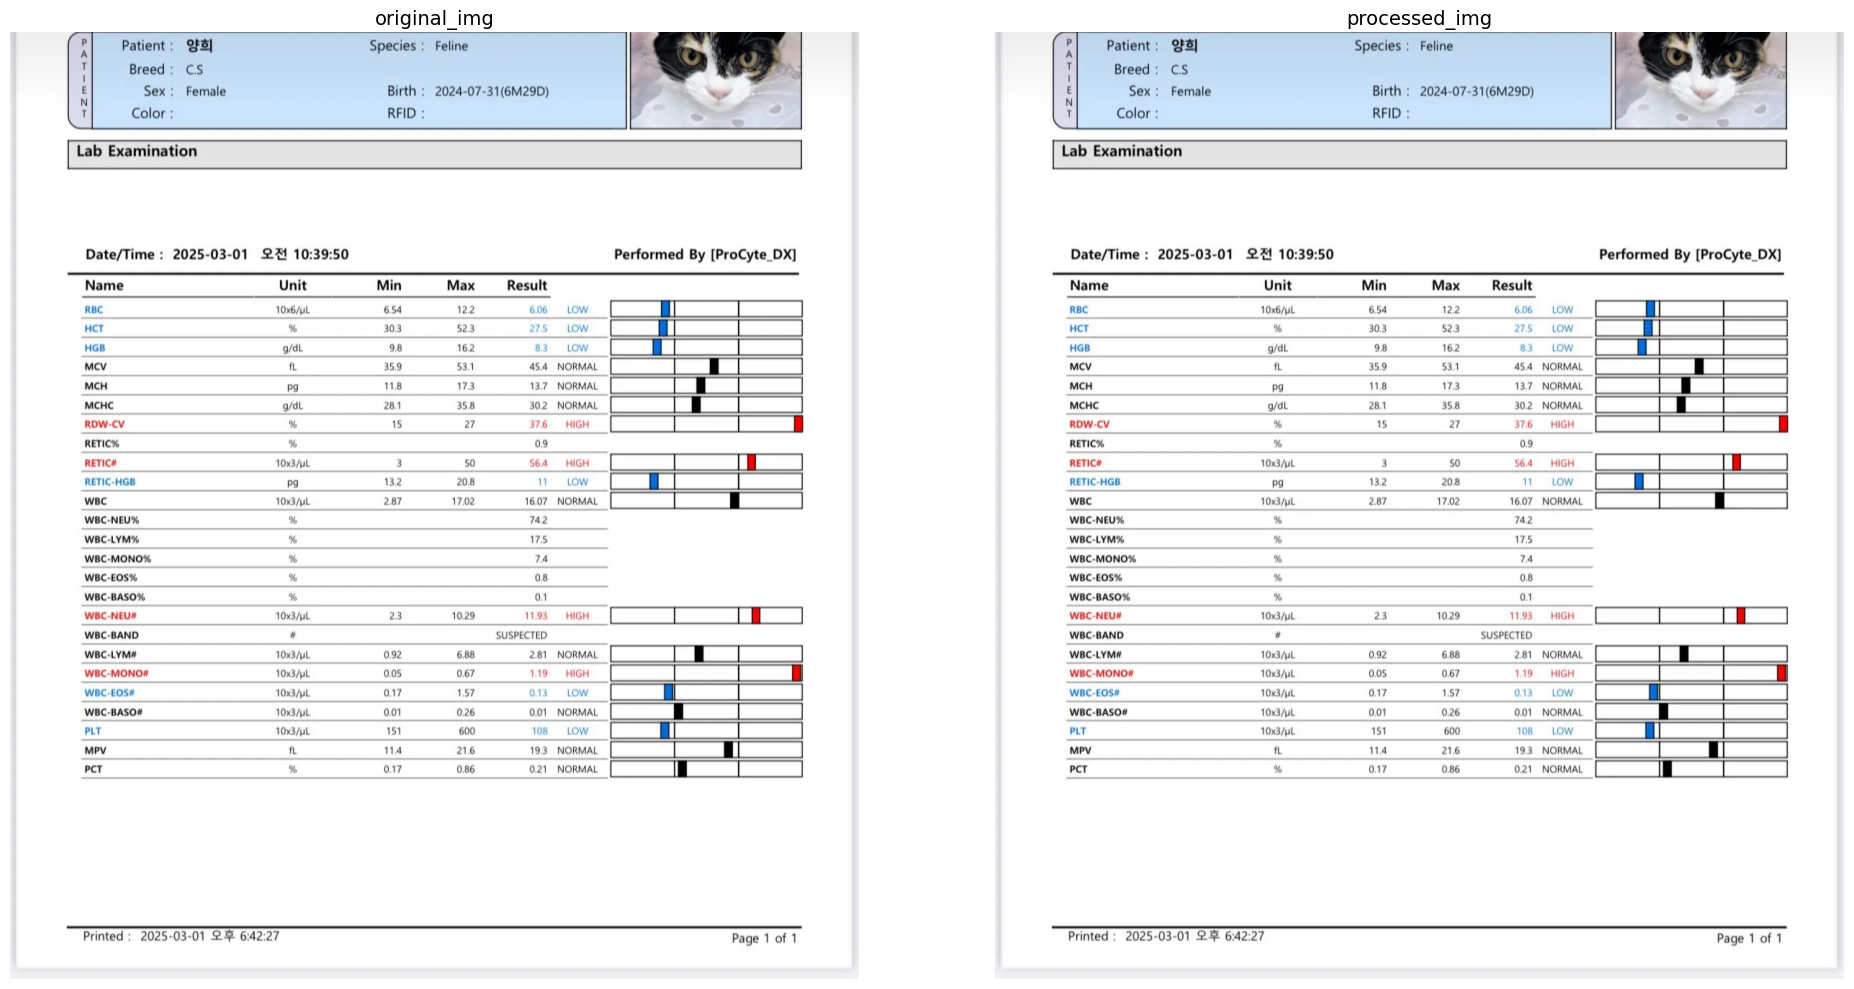

In [5]:
import io
from PIL import Image as PILImage
import matplotlib.pyplot as plt

# bytes를 PIL Image로 변환
processed_img = PILImage.open(io.BytesIO(_pre_bytes))

# 원본과 전처리된 이미지를 함께 표시
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 원본 이미지
original_img = PILImage.open(img_path)
axes[0].imshow(original_img)
axes[0].set_title('original_img', fontsize=14)
axes[0].axis('off')

# 전처리된 이미지
if processed_img.mode == 'L':  # 그레이스케일
    axes[1].imshow(processed_img, cmap='gray', vmin=0, vmax=255)
else:  # 컬러
    axes[1].imshow(processed_img)
axes[1].set_title('processed_img', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Step 3. PaddleOCR 수행

In [6]:
# PaddleOCRService 초기화
import paddleocr
from paddleocr import PaddleOCR
import inspect
from app.services.ocr.paddle_ocr import PaddleOCRService

# 서버급 조합(정확도 지향): PP-OCRv5_server_det + korean_PP-OCRv5_server_rec
# 필요 시 파라미터는 추가로 조정 가능: text_det_limit_side_len, text_det_thresh, text_rec_score_thresh 등
ocr = PaddleOCRService(lang="korean")

print(f"\n🔍 현재 PaddleOCR 버전: {paddleocr.__version__}")

# PaddleOCR 생성자의 파라미터 확인
# signature = inspect.signature(PaddleOCR.__init__)
# print(f"\n📋 지원하는 파라미터:")
# for param_name, param in signature.parameters.items():
#     if param_name != 'self':
#         default = param.default if param.default != inspect.Parameter.empty else "필수"
#         print(f"   {param_name}: {default}")  

# ocr.get_available_langs()
# ocr.get_available_models()
# info = ocr.get_current_model_info()
# print(info) 
# ocr.get_current_preprocessing_settings()          

/home/aidan/.local/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/aidan/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/aidan/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/aidan/.paddlex/official_models/UVDoc`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached


🔍 현재 PaddleOCR 버전: 3.2.0


In [7]:
# OCR 실행
print(f"🔍 OCR 분석 시작: {img_path}")
try:
    ocr_result = ocr.run_ocr_from_bytes(_pre_bytes)
    print("✅ OCR 처리 완료!")
    print(ocr_result)
except Exception as e:
    print(f"❌ OCR 처리 중 오류 발생: {e}")
    print(f"오류 타입: {type(e).__name__}")

🔍 OCR 분석 시작: /home/aidan/work/meow-chat/notebooks/ocr/assets/images/20250301.png
✅ OCR 처리 완료!
[{'input_path': None, 'page_index': None, 'doc_preprocessor_res': {'input_path': None, 'page_index': None, 'input_img': array([[[226, ..., 220],
        ...,
        [224, ..., 220]],

       ...,

       [[248, ..., 242],
        ...,
        [248, ..., 242]]], shape=(1920, 1721, 3), dtype=uint8), 'model_settings': {'use_doc_orientation_classify': True, 'use_doc_unwarping': True}, 'angle': 0, 'rot_img': array([[[226, ..., 220],
        ...,
        [224, ..., 220]],

       ...,

       [[248, ..., 242],
        ...,
        [248, ..., 242]]], shape=(1920, 1721, 3), dtype=uint8), 'output_img': array([[[243, ..., 243],
        ...,
        [243, ..., 243]],

       ...,

       [[255, ..., 255],
        ...,
        [255, ..., 255]]], shape=(1920, 1721, 3), dtype=uint8)}, 'dt_polys': [array([[123,  19],
       ...,
       [123,  46]], shape=(4, 2), dtype=int16), array([[219,  22],
       ...,


### Step 4. 라인 정렬 및 값/단위 분리

In [8]:
# LinePreprocessor 초기화

from app.services.analysis.line_preprocessor import LinePreprocessor, Settings as LPSettings
from app.services.analysis.reference.unit_lexicon import get_unit_lexicon

unit_lex = get_unit_lexicon()  # 전역 유닛 렉시콘(캐시)

lp = LinePreprocessor(LPSettings(
    order="x_left",
    alpha=0.7,
    debug=True,
    normalize_units_first_pass=True,  # 분리 직후 1차 단위 정규화 
), unit_lexicon=unit_lex)


In [9]:
# 4.1 ~ 4.6 통합 실행
ocr_lined_data = lp.extract_and_group_lines(
    ocr_result[0]
)

print("📋 OCR 결과(LinePreprocessor):")
for i, item in enumerate(ocr_lined_data, 1):
    print(f"  {i}. {item}")

[DEBUG] tokens_with_geometry: count=149
[
  {
    "text": "T",
    "confidence": 0.8590347170829773,
    "y_top": 19,
    "y_bottom": 46,
    "y_center": 32,
    "raw_h": 27,
    "x_left": 123,
    "x_right": 139
  },
  {
    "text": "Breed: C.S",
    "confidence": 0.9527930021286011,
    "y_top": 22,
    "y_bottom": 64,
    "y_center": 43,
    "raw_h": 42,
    "x_left": 218,
    "x_right": 384
  },
  {
    "text": "|",
    "confidence": 0.29836124181747437,
    "y_top": 50,
    "y_bottom": 71,
    "y_center": 60,
    "raw_h": 21,
    "x_left": 123,
    "x_right": 139
  },
  {
    "text": "E",
    "confidence": 0.9881343245506287,
    "y_top": 74,
    "y_bottom": 100,
    "y_center": 87,
    "raw_h": 26,
    "x_left": 122,
    "x_right": 141
  },
  {
    "text": "Sex: Female",
    "confidence": 0.9245815873146057,
    "y_top": 70,
    "y_bottom": 112,
    "y_center": 91,
    "raw_h": 42,
    "x_left": 249,
    "x_right": 431
  },
  {
    "text": "Birth: 2024-07-31(6M29D)",
    "confide

### Step 5. 테이블 바디 시작 검출 및 바디 필터링

In [10]:
# 검사항목 코드 목록
import importlib
import app.services.analysis.reference.code_lexicon as cl
cl = importlib.reload(cl)  # 모듈 재로딩: 새로운 resolve_code 로직 반영

# 최신 렉시콘 획득 (캐시 재빌드는 참조 데이터가 바뀔 때만 필요)
code_lexicon = cl.get_code_lexicon()
codes = sorted(cl.list_all_codes())
print(f"\n📋 테스트용 코드 렉시콘 (총 {len(codes)}개, 상위 80개 미리보기):")
print(", ".join(codes[:80]))

# 가벼운 리졸버 자체 테스트 (OCR 0↔O 보정 확인)
for s in ["p02", "P02(T)", "p02(A-a)", "s02", "pO2", "sO2", "CO2", "C02"]:
    print(f"  {s!r} -> {cl.resolve_code(s, code_lexicon)}")



📋 테스트용 코드 렉시콘 (총 169개, 상위 80개 미리보기):
AG, ALB, ALB/GLOB, ALKP, ALP, ALT, AMYL, AST, AST/GOT, A_G, Albumin, AnGap, BA, BASO, BASO%, BB, BE, BE(Art), BE(Ven), BE-Ecf, BIL, BIL-Total, BLO, BP, BUN, BUN/CRE, BUN/CREA, Bacteria, CHOL, CHOL_HDL_RATIO, CHr, CK, COHb, CORT, CPK, CRE, CREA, CRP, Ca, Ca++, Cl-, Crystals, EOS%, EOSIN, FHHb, FIB, FIV, FO2Hb, FSAA, FT4, FeLV, Fructosamine, GGT, GLOB, GLOB(calc), GLU, GLU_U, Globulin, HCO3, HCO3(Art), HCO3(Ven), HCO3-Std, HCT, HDL_C, HGB, Heartworm Ag, IP, K+, KET, LAC, LDH, LDL_C, LIPA, LYM, LYM%, LYMPH, LYMPH%, LYMPHO%, Lac(Art), Lac(Ven)
  'p02' -> pO2
  'P02(T)' -> PO2(T)
  'p02(A-a)' -> pO2(A-a)
  's02' -> sO2
  'pO2' -> pO2
  'sO2' -> sO2
  'CO2' -> None
  'C02' -> None


In [11]:
# LabTableExtractor 초기화, 실행
import importlib
import app.services.analysis.lab_table_extractor as lte
lte = importlib.reload(lte)
LabTableExtractor = lte.LabTableExtractor
Settings = lte.Settings

# 최신 code_lexicon 모듈과 resolver 주입
import app.services.analysis.reference.code_lexicon as cl
cl = importlib.reload(cl)
code_lexicon = cl.get_code_lexicon()  # 캐시 사용 (참조 데이터 변경 없을 때 추천)

from openai import OpenAI

# OpenAI 클라이언트 초기화
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# LLM 호출은 정책 미달 시에만 사용. resolver를 명시적으로 주입하여 0→O 폴백이 반드시 적용되도록 함.
extractor = LabTableExtractor(
    settings=Settings(use_llm=True, debug=True),  # 정책 미달 시에만 LLM 백업 사용
    lexicon=code_lexicon,
    resolver=cl.resolve_code,  # ← 중요: 최신 resolve_code를 명시 주입
    llm_client=client,
    llm_model="gpt-4.1-mini",
)
doc_result, intermediates = extractor.extract_from_lines(ocr_lined_data, return_intermediates=True)

In [12]:
# ocr_lined_data 에서 테이블 바디 추출
# - 라인의 첫 토큰을 검사코드로 해석(resolve_test_code)하여 최초 적중 라인을 바디 시작으로 간주
# - 바디 시작 이후 라인 중 첫 토큰이 코드로 해석되지 않으면 바디에서 제외(디버그 출력)
# - 정상 인식된 경우, 첫 토큰의 텍스트를 canonical 코드(해석값)로 교체하여 이후 단계의 일관성 확보

# Step 5 디버그 출력 
# - 미리보기 제한 해제: preview_limit/dropped_limit 인자를 생략하면 전체 라인을 출력합니다.
print(extractor.debug_step5(intermediates, show_full_lines=False))

✅ 바디 시작 인덱스: 7
📦 바디 라인 수: 24

🔎 바디 라인 미리보기:
 - line#7: RBC | M/µL | 6.54 | 12.2 | 6.06
 - line#8: HCT | % | 30.3 | 52.3 | 27.5
 - line#9: HGB | g/dL | 9.8 | 16.2 | 8.3
 - line#10: MCV | fL | 35.9 | 53.1 | 45.4
 - line#11: MCH | pg | 11.8 | 17.3 | 13.7
 - line#12: MCHC | g/dL | 28.1 | 35.8 | 30.2
 - line#13: RDW-CV | % | 15 | 27 | 37.6
 - line#14: RETIC | % | 0.9
 - line#15: RETIC | K/µL | 3 | 50 | 56.4
 - line#16: RETIC-HGB | pg | 13.2 | 20.8 | 11
 - line#17: WBC | K/µL | 2.87 | 17.02 | 16.07
 - line#18: WBC-NEU% | % | 74.2
 - line#19: WBC-LYM% | % | 17.5
 - line#20: WBC-MONO% | % | 7.4
 - line#21: WBC-EOS% | % | 0.8
 - line#22: WBC-BASO% | % | 0.1
 - line#23: WBC-NEU | K/µL | 2.3 | 10.29 | 11.93
 - line#25: WBC-LYM | K/µL | 0.92 | 6.88 | 2.81
 - line#26: WBC-MONO | K/µL | 0.05 | 0.67 | 1.19
 - line#27: WBC-EOS | K/µL | 0.17 | 1.57 | 0.13
 - line#28: WBC-BASO | 10 | x3/μL | 0.01 | 0.26 | 0.01
 - line#29: PLT | K/µL | 151 | 600 | 108
 - line#30: MPV | fL | 11.4 | 21.6 | 19.3
 - line#31:

### Step 6. 헤더 추출(검증 → 규칙 추론 → LLM 백업)

In [13]:
# Step 6 디버그 출력
print(extractor.debug_step6(intermediates, show_full_header_line=False))

🧭 헤더 인덱스: 6
🔎 헤더 출처: ocr
🖹 헤더 텍스트: Name | Unit | Min | Max | Result
✅ 헤더 유효성: True (roles=5, threshold=3) | 정책기준: True (필수: name+unit+result + ref|min/max)


📏 역할 매핑:
 - name: label='Name' col_index=0 hits=['name'] conf=1.0
 - unit: label='Unit' col_index=1 hits=['unit'] conf=1.0
 - min: label='Min' col_index=2 hits=['min'] conf=1.0
 - max: label='Max' col_index=3 hits=['max'] conf=1.0
 - result: label='Result' col_index=4 hits=['result'] conf=1.0


### Step 7. 상단 메타데이터 추출

In [14]:
# Step 7 디버그 출력
# - 메타데이터(병원/의뢰인/환자/검사일) 후보와 상위 K개를 출력합니다.
# - extractor.extract_from_lines(..., return_intermediates=True)로 생성한 intermediates를 사용합니다.
print(extractor.debug_step7(intermediates, show_top_k=10))

# 선택: 최종 선택된 메타데이터도 함께 확인하고 싶다면 주석 해제
# print("\n선택된 메타데이터 (doc_result):")
# for k in ("hospital_name", "client_name", "patient_name", "inspection_date"):
#     print(f" - {k}: {doc_result.get(k)}")

🧾 메타데이터 추출 결과 요약
 - 스캔 라인 수: 7 (end_index=6)
 - hospital_name: 후보 없음
 - client_name: 후보 없음
 - patient_name: 후보 없음
 - inspection_date: 후보 2개 (상위 2):
    1. [date-pattern] score=2.0 line=5 | 2025-03-01
    2. [date-pattern] score=1.5 line=2 | 2024-07-31


### Step 8. 테이블 Filling (UNKNOWN 채우기)

In [15]:
# Step 8 디버그 출력
# - Filling(UNKNOWN) 이후 정렬된 행(Name | Reference | Result | Unit) 전체 출력
# - extractor.extract_from_lines(..., return_intermediates=True) 호출로 생성한 intermediates를 사용합니다.
print(extractor.debug_step8(intermediates))

🧩 Step 8: Filling 결과 (정렬된 표, 전체)
Name      | Unit     |     Min |     Max | Result
----------+----------+---------+---------+-------
RBC       | M/µL     |    6.54 |    12.2 |   6.06
HCT       | %        |    30.3 |    52.3 |   27.5
HGB       | g/dL     |     9.8 |    16.2 |    8.3
MCV       | fL       |    35.9 |    53.1 |   45.4
MCH       | pg       |    11.8 |    17.3 |   13.7
MCHC      | g/dL     |    28.1 |    35.8 |   30.2
RDW-CV    | %        |      15 |      27 |   37.6
RETIC     | %        | UNKNOWN | UNKNOWN |    0.9
RETIC     | K/µL     |       3 |      50 |   56.4
RETIC-HGB | pg       |    13.2 |    20.8 |     11
WBC       | K/µL     |    2.87 |   17.02 |  16.07
WBC-NEU%  | %        | UNKNOWN | UNKNOWN |   74.2
WBC-LYM%  | %        | UNKNOWN | UNKNOWN |   17.5
WBC-MONO% | %        | UNKNOWN | UNKNOWN |    7.4
WBC-EOS%  | %        | UNKNOWN | UNKNOWN |    0.8
WBC-BASO% | %        | UNKNOWN | UNKNOWN |    0.1
WBC-NEU   | K/µL     |     2.3 |   10.29 |  11.93
WBC-LYM   | K/µL 

### Step 9. 행 길이 정규화(뒤에서 자르기)

In [16]:
# Step 9 디버그 출력
"""
- 행 길이 정규화(뒤에서 자르기) 후(Name | Reference | Result | Unit | _fix) 전체 출력
- extractor.extract_from_lines(..., return_intermediates=True)로 생성한 intermediates를 사용합니다.
"""
print(extractor.debug_step9(intermediates))

🧪 Step 9: 행 길이 정규화(뒤에서 자르기) 결과(전체)
Name      | Reference | Result | Unit     | _fix
----------+-----------+--------+----------+-----
RBC       |           |   6.06 | M/µL     |     
HCT       |           |   27.5 | %        |     
HGB       |           |    8.3 | g/dL     |     
MCV       |           |   45.4 | fL       |     
MCH       |           |   13.7 | pg       |     
MCHC      |           |   30.2 | g/dL     |     
RDW-CV    |           |   37.6 | %        |     
RETIC     |           |    0.9 | %        |     
RETIC     |           |   56.4 | K/µL     |     
RETIC-HGB |           |     11 | pg       |     
WBC       |           |  16.07 | K/µL     |     
WBC-NEU%  |           |   74.2 | %        |     
WBC-LYM%  |           |   17.5 | %        |     
WBC-MONO% |           |    7.4 | %        |     
WBC-EOS%  |           |    0.8 | %        |     
WBC-BASO% |           |    0.1 | %        |     
WBC-NEU   |           |  11.93 | K/µL     |     
WBC-LYM   |           |   2.81 | K

### Step 10. Reference 분리

In [17]:
# Step 10 디버그 출력
"""
- Reference → Min/Max 분리 후(Name | Min | Max | Result | Unit) 전체 출력
- extractor.extract_from_lines(..., return_intermediates=True)로 생성한 intermediates를 사용합니다.
"""
print(extractor.debug_step10(intermediates))

🧪 Step 10: Reference → Min/Max 분리 결과(전체)
Name      |     Min |     Max | Result | Unit    
----------+---------+---------+--------+---------
RBC       |    6.54 |    12.2 |   6.06 | M/µL    
HCT       |    30.3 |    52.3 |   27.5 | %       
HGB       |     9.8 |    16.2 |    8.3 | g/dL    
MCV       |    35.9 |    53.1 |   45.4 | fL      
MCH       |    11.8 |    17.3 |   13.7 | pg      
MCHC      |    28.1 |    35.8 |   30.2 | g/dL    
RDW-CV    |      15 |      27 |   37.6 | %       
RETIC     | UNKNOWN | UNKNOWN |    0.9 | %       
RETIC     |       3 |      50 |   56.4 | K/µL    
RETIC-HGB |    13.2 |    20.8 |     11 | pg      
WBC       |    2.87 |   17.02 |  16.07 | K/µL    
WBC-NEU%  | UNKNOWN | UNKNOWN |   74.2 | %       
WBC-LYM%  | UNKNOWN | UNKNOWN |   17.5 | %       
WBC-MONO% | UNKNOWN | UNKNOWN |    7.4 | %       
WBC-EOS%  | UNKNOWN | UNKNOWN |    0.8 | %       
WBC-BASO% | UNKNOWN | UNKNOWN |    0.1 | %       
WBC-NEU   |     2.3 |   10.29 |  11.93 | K/µL    
WBC-LYM  

### Step 11. Unit/Result 정규화

In [18]:
# Step 11 디버그 출력
"""
- Unit/Result 정규화 미리보기(Name | Result | result_norm | Unit | unit_canonical | Min | min_norm | Max | max_norm) 전체 출력
- extractor.extract_from_lines(..., return_intermediates=True)로 생성한 intermediates를 사용합니다.
"""
print(extractor.debug_step11(intermediates))

🧪 Step 11: Unit/Result 정규화 결과(전체)
Name      | Result | result_norm | Unit     | unit_canonical |     Min | min_norm |     Max | max_norm
----------+--------+-------------+----------+----------------+---------+----------+---------+---------
RBC       |   6.06 |        6.06 | M/µL     | M/µL           |    6.54 |     6.54 |    12.2 |     12.2
HCT       |   27.5 |        27.5 | %        | %              |    30.3 |     30.3 |    52.3 |     52.3
HGB       |    8.3 |         8.3 | g/dL     | g/dL           |     9.8 |      9.8 |    16.2 |     16.2
MCV       |   45.4 |        45.4 | fL       | fL             |    35.9 |     35.9 |    53.1 |     53.1
MCH       |   13.7 |        13.7 | pg       | pg             |    11.8 |     11.8 |    17.3 |     17.3
MCHC      |   30.2 |        30.2 | g/dL     | g/dL           |    28.1 |     28.1 |    35.8 |     35.8
RDW-CV    |   37.6 |        37.6 | %        | %              |      15 |       15 |      27 |       27
RETIC     |    0.9 |         0.9 | %   

### Step 12. 최종 필터링 (UNKNOWN/신뢰도/중복) — 제외된 tests 미리보기

In [19]:
# Step 12 디버그 출력
"""
- Step 12: 제외된 tests(필터 사유 포함)만 출력합니다.
  컬럼: code | value | unit | reference_min | reference_max | reason | value_conf
"""
step12_output = extractor.debug_step12(intermediates)
print(step12_output)

🧾 Step 12: 포함/제외 tests 전체 (라인 순)
code      | value | value_conf | unit     | reference_min | reference_max | drop_reason              
----------+-------+------------+----------+---------------+---------------+--------------------------
RBC       |  6.06 |      0.950 | M/µL     |          6.54 |          12.2 |                          
HCT       |  27.5 |      0.950 | %        |          30.3 |          52.3 |                          
HGB       |   8.3 |      0.950 | g/dL     |           9.8 |          16.2 |                          
MCV       |  45.4 |      1.000 | fL       |          35.9 |          53.1 |                          
MCH       |  13.7 |      1.000 | pg       |          11.8 |          17.3 |                          
MCHC      |  30.2 |      1.000 | g/dL     |          28.1 |          35.8 |                          
RDW-CV    |  37.6 |      0.950 | %        |          15.0 |          27.0 |                          
RETIC     |   0.9 |      1.000 | %        |      

### Step 13. 최종 JSON 및 QA 요약

In [20]:
# Step 13 디버그 출력
"""
- Step 13: 최종 JSON(전체) + QA 요약(value_conf 포함)
"""
step13_output = extractor.debug_step13(intermediates)
print(step13_output)

🏥 hospital_name: (None)
👤 client_name  : (None)
🐾 patient_name : (None)
🗓  inspection_date: 2025-03-01

🧾 Step 13: 최종 JSON
code      | value | unit     | reference_min | reference_max
----------+-------+----------+---------------+--------------
RBC       |  6.06 | M/µL     |          6.54 |          12.2
HCT       |  27.5 | %        |          30.3 |          52.3
HGB       |   8.3 | g/dL     |           9.8 |          16.2
MCV       |  45.4 | fL       |          35.9 |          53.1
MCH       |  13.7 | pg       |          11.8 |          17.3
MCHC      |  30.2 | g/dL     |          28.1 |          35.8
RDW-CV    |  37.6 | %        |          15.0 |          27.0
RETIC     |  56.4 | K/µL     |           3.0 |          50.0
RETIC-HGB |  11.0 | pg       |          13.2 |          20.8
WBC       | 16.07 | K/µL     |          2.87 |         17.02
WBC-NEU%  |  74.2 | %        |       UNKNOWN |       UNKNOWN
WBC-LYM%  |  17.5 | %        |       UNKNOWN |       UNKNOWN
WBC-MONO% |   7.4 | %  